# Классификация заемщиков линейными моделями

## курс "Машинное обучение 1", программа AIMasters, 2024

## Студент: Нафикова Лиана

## Реализация алгоритмов (5 баллов)

Ниже нужно написать собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит тесты. В этом блоке можно использовать только `numpy, scipy`.


В `BinaryLogisticLoss` вам нужно реализовать расчет лосса и его градиента для функции 
$$L(w) = \frac{1}{N} \sum_{N} [\log(1 + \exp(-y_i\langle w, x_i\rangle))] + \lambda \lVert w \rVert^2_2, \quad y \in \{-1, 1\}$$

- `func(self, X, y, w)` — вычисление значения функции потерь на матрице признаков X, векторе ответов y с вектором весов w.
- `grad(self, X, y, w)` — вычисление значения градиента функции потерь на матрице признаков X, векторе ответов y с вектором весов w.

У обоих методов одинаковые аргументы:
- X - выборка объектов
- y - вектор ответов
- w - вектор коэффициентов модели

Вектор коэффициентов имеет вид: w = `[bias, weights]`, то есть нулевой элемент w - `bias`, остальное - веса, участвующие в скалярном произведении. **Важно:** `bias` не участвует в расчете слагаемого с $\lambda$.

Обратите внимание, что на матрица X на входе без столбца с 1 в начале. Пример изменения Х внутри кода функций:
```python
X_new = np.c_[np.ones(X.shape[0]), X]
```

In [1]:
import time
from functools import partial

import numpy as np
np.random.seed(42)

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

import optuna
from optuna.visualization import plot_slice
from optuna.visualization import plot_contour

c:\Users\Лиана\OneDrive\Desktop\ML1\Machine-learning-1\notebooks\homeworks\log-reg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class BinaryLogisticLoss():
    """
    Loss function for binary logistic regression.
    It should support l2 regularization.
    """

    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef
        

    def func(self, X, y, w):
        """
        Get loss function value for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        N = X.shape[0]
        X_new = np.c_[np.ones(N), X]
        predictions = np.dot(X_new, w)
        loss = np.logaddexp(0, -y * predictions)
        mean_loss = np.mean(loss)
        regularization = self.l2_coef * np.dot(w[1:], w[1:])
        return mean_loss + regularization

    def grad(self, X, y, w):
        """
        Get loss function gradient for data X, target y and coefficient w; w = [bias, weights].

        Parameters
        ----------
        X : numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : 1d numpy.ndarray
        """
        N = X.shape[0]
        X = np.c_[np.ones(N), X]
        predictions = np.dot(X, w)
        
        sigmoid = 1 / (1 + np.exp(-predictions))
        error = sigmoid - (y + 1) / 2
        
        grad_loss = np.dot(X.T, error) / N
        grad_reg = np.concatenate(([0], 2 * self.l2_coef * w[1:]))
        return grad_loss + grad_reg

In [5]:
loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
assert np.isclose(loss_function.func(X, y, w), 16.00008, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 5],
    [-10 ** 5],
    [10 ** 5]
])
y = np.array([1, -1, 1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 0, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=0.0)
X = np.array([
    [10 ** 2],
    [-10 ** 2],
    [10 ** 2]
])
y = np.array([-1, 1, -1])
w = np.array([1, 100])
assert np.isclose(loss_function.func(X, y, w), 10000.333334, atol=1e-5)

loss_function = BinaryLogisticLoss(l2_coef=1.0)
X = np.array([
    [1, 2],
    [3, 4],
    [-5, 6]
])
y = np.array([-1, 1, 1])
w = np.array([1, 2, 3])
right_gradient = np.array([0.33325, 4.3335 , 6.66634])
assert np.isclose(loss_function.grad(X, y, w), right_gradient, atol=1e-5).all()

В `LinearModel` нужно реализовать линейную модель, поддерживающей обучение через стохастический градиентные спуск.

`__init__` — инициализатор класса с параметрами:
- loss_function — функция потерь, заданная классом
- batch_size — размер подвыборки, по которой считается градиент
- step_alpha — параметр шага градиентного спуска 
- tolerance — критерий останова метода — модуль разности значений функции потерь на соседних итерациях метода меньше tolerance, не весов.
- max_iter — максимальное число итераций (эпох)

`fit(self, X, y, w_0=None)` — обучение линейной модели

- X — выборка объектов
- y — вектор ответов
- w_0 — начальное приближение вектора коэффициентов, если None, то необходимо инициализировать внутри метода. w_0 имеет вид `[bias_0, weights_0]`.

`predict_proba(self, X)` — получение вероятностей для 2х классов
- X — выборка объектов

Вы можете поменять формат изменения шага градиентного спуска, по дефолту предполагается, что можно использовать просто `step_alpha`.

Про sgd: нет необходимости проводить честное семплирование для каждого батча в методе стохасического градиентного спуска. Вместо этого предлагается в начале одной эпохи сгенерировать случайную перестановку индексов объектов, а затем последовательно выбирать объекты для нового батча из элементов этой перестановки. Псевдокод:
```python
epoch_rand_indexes = np.random.permutation(X.shape[0])
inner_cycle_length = int(np.ceil(X.shape[0] / self.batch_size))

for i in range(inner_cycle_length):
    start_index = self.batch_size * i
    finish_index = self.batch_size * (i + 1)
    batch_indexes = epoch_rand_indexes[start_index:finish_index]
    # тут считаем градиент только по batch_indexes
```

Еще несколько советов:

В промежуточных вычислениях стоит избегать вычисления $exp(−y_i⟨x_i,w⟩)$, иначе может произойти переполнение.
Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp, scipy.special.logsumexp и scipy.special.expit`. В ситуации, когда вычисления экспоненты обойти не удаётся, можно воспользоваться процедурой «клипинга» (функция `numpy.clip`).


In [ ]:
class LinearModel:
    def __init__(
        self,
        loss_function,
        batch_size=100,
        step_alpha=1,
        tolerance=1e-5,
        max_iter=1000,
        random_seed=0,
        **kwargs
    ):
        """
        Parameters
        ----------
        loss_function : BaseLoss inherited instance
            Loss function to use
        batch_size : int
        step_alpha : float
        tolerance : float
            Tolerace for stop criterio.
        max_iter : int
            Max amount of epoches in method.
        """
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        
        np.random.seed(random_seed)

    def fit(self, X, y, w_0=None):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, training set.
        y : numpy.ndarray
            1d vector, target values.
        w_0 : numpy.ndarray
            1d vector in binary classification.
            Initial approximation for SGD method - [bias, weights]
        """
        n_samples, _ = X.shape

        if w_0 is None:
            w_k = np.zeros(X.shape[1] + 1) # [bias, weights]
        else:
            w_k = w_0
            
        prev_loss = np.inf

        for _ in range(self.max_iter):
            epoch_rand_indexes = np.random.permutation(n_samples)
            inner_cycle_length = int(np.ceil(n_samples / self.batch_size))

            for i in range(inner_cycle_length):
                start_index = i * self.batch_size
                finish_index = min((i + 1) * self.batch_size, n_samples)
                batch_indexes = epoch_rand_indexes[start_index:finish_index]
                X_batch = X[batch_indexes]
                y_batch = y[batch_indexes]

                gradients = self.loss_function.grad(X_batch, y_batch, w_k)
                w_k -= self.step_alpha * gradients

            current_loss = self.loss_function.func(X, y, w_k)

            if np.linalg.norm(prev_loss - current_loss) < self.tolerance:
                break

            prev_loss = current_loss
        self.weights = w_k

    def predict_proba(self, X):
        """
        Parameters
        ----------
        X : numpy.ndarray or scipy.sparse.csr_matrix
            2d matrix, test set.
        Returns
        -------
        : numpy.ndarray
            probs, shape=(X.shape[0], 2)
        """
        n_samples, _ = X.shape
        X_with_bias = np.c_[np.ones(n_samples), X]
        scores = X_with_bias @ self.weights
        probabilities_class_1 = expit(scores)  
        probabilities_class_0 = 1 - probabilities_class_1  
        return np.column_stack((probabilities_class_0, probabilities_class_1))

In [322]:
# обратите внимание, что тут достаточно простой тест
# ниже еще есть проверка для данных из data
X1 = np.random.randint(1, 4, (1000, 10))
X2 = np.random.randint(-4, 0, (1000, 10))
X = np.vstack((X1, X2))
y = np.array([-1] * 1000 + [1] * 1000)
loss_function = BinaryLogisticLoss(l2_coef=0.1)
linear_model = LinearModel(
    loss_function=loss_function,
    batch_size=100,
    step_alpha=1,
    tolerance=1e-4,
    max_iter=1000,
)
linear_model.fit(X, y)
prediction_probs = linear_model.predict_proba(X)
predictions = (prediction_probs > 0.5).astype('int')[:, 1] * 2 - 1
assert np.isclose(predictions, y).all()

## Эксперименты (5 баллов)

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). Для экспериментов будем использовать лишь основной файл `application_train.csv`, а также перекодируем таргет в метки -1, 1.

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение и тест.

Код в чтение, разбиение и предобработке менять не нужно.

Выполняя задания, не забывайте про [устав](https://t.me/c/2206639786/270/271).

In [2]:
# не меняем код
data = pd.read_csv('application_train.csv')
data.columns = [
    '_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns
]
data.target = data.target.map({0: -1, 1: 1})
data.head(3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


In [4]:
# не меняем код
features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

X_tr, X_tst = data_dict["tr"][features].to_numpy(), data_dict["tst"][features].to_numpy()
y_tr, y_tst = data_dict["tr"]["target"].to_numpy(), data_dict["tst"]["target"].to_numpy()


prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

prep.fit(X_tr)

X_tr = prep.transform(X_tr)
X_tst = prep.transform(X_tst)

Инициализируйте написанный выше лосс и классификатор, для `BinaryLogisticLoss` возьмите параметр `l2_coef=0.1`, параметры `LinearModel` нужно подобрать так, чтобы [roc_auc_score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html) был больше 0.72.

In [353]:
loss_function = BinaryLogisticLoss(l2_coef=0.1)
clf = LinearModel(loss_function=loss_function,
    batch_size=439,
    step_alpha=0.0009,
    tolerance=0.000001,
    max_iter=50)

In [354]:
clf.fit(X_tr, y_tr)

In [ ]:
roc_auc = roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1])
print(f'ROC AUC: = {roc_auc}')
assert roc_auc > 0.72

ROC AUC: = 0.7212565094182284


Ура! Ваша модель что-то может :)

Теперь нужно поисследовать реализацию [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) в sklearn.

Сравните различные `solver` по времени обучения/качеству на тесте. Напишите выводы.

Выбейте на тесте больше `0.737` roc_auc_score.
Для поиска лучшей модели можно использовать:
- optuna
- [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
- свои наблюдения и интуицию

In [5]:
def objective(
    trial: optuna.trial.Trial, 
    X_tr, X_val, y_tr, y_val 
):
    '''
    Принимает на вход трейн и валидацию.
    Обучает модель на предложенном наборе гиперпараметров (предлагает optuna) и считает roc_auc_score и время обучения
    
    returns: roc_auc_score 
    '''
    solver =  trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    C = trial.suggest_float('C', 1e-4, 1e2)
    max_iter = trial.suggest_int('max_iter', 50, 1000, log=True)

    start_time = time.time()
    model = LogisticRegression(solver=solver, penalty='l2', C=C, max_iter=max_iter, random_state=42)
    model.fit(X_tr, y_tr)
    train_time = time.time() - start_time
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)
    
    trial.set_user_attr('train_time', train_time)
    return score

In [6]:
study = optuna.create_study(direction='maximize')
obj_func = partial(objective, X_tr=X_tr, X_val=X_tst, y_tr=y_tr, y_val=y_tst)
study.optimize(obj_func, n_trials=100, n_jobs=6, gc_after_trial=True) 

[I 2024-11-15 14:43:11,455] A new study created in memory with name: no-name-4a988b2c-2e2a-4a05-9cfa-a818c34648dc
[I 2024-11-15 14:43:24,743] Trial 1 finished with value: 0.7352815633922245 and parameters: {'solver': 'lbfgs', 'C': 66.59440537141086, 'max_iter': 50}. Best is trial 1 with value: 0.7352815633922245.
[I 2024-11-15 14:44:46,657] Trial 5 finished with value: 0.7380019285644996 and parameters: {'solver': 'newton-cg', 'C': 37.36403629816217, 'max_iter': 243}. Best is trial 5 with value: 0.7380019285644996.
[I 2024-11-15 14:45:17,115] Trial 4 finished with value: 0.7380293281667105 and parameters: {'solver': 'newton-cg', 'C': 64.70826032221142, 'max_iter': 106}. Best is trial 4 with value: 0.7380293281667105.
[I 2024-11-15 14:45:18,012] Trial 3 finished with value: 0.7380125288023777 and parameters: {'solver': 'newton-cg', 'C': 22.63179801959134, 'max_iter': 220}. Best is trial 4 with value: 0.7380293281667105.
[I 2024-11-15 14:45:25,166] Trial 6 finished with value: 0.73800885

In [7]:
best_trial = study.best_trial
print(f"Лучший `solver`: {best_trial.params['solver']}")
print(f"Лучший параметр `C`: {best_trial.params['C']}")
print(f"Лучший параметр `max_iter`: {best_trial.params['max_iter']}")
print(f"ROC AUC Score: {best_trial.value}")
print(f"Время обучения: {best_trial.user_attrs['train_time']} секунд")

solver_times = {}
for trial in study.trials:
    solver = trial.params['solver']
    train_time = trial.user_attrs.get('train_time')
    if train_time is not None:
        if solver not in solver_times:
            solver_times[solver] = []
        solver_times[solver].append(train_time)

print("\nСреднее время обучения для каждого `solver`:")
for solver, times in solver_times.items():
    print(f"{solver}: {np.mean(times):.4f} секунд")

Лучший `solver`: liblinear
Лучший параметр `C`: 97.53224851870195
Лучший параметр `max_iter`: 176
ROC AUC Score: 0.7380427256676592
Время обучения: 248.90099930763245 секунд

Среднее время обучения для каждого `solver`:
sag: 237.0670 секунд
lbfgs: 4.9432 секунд
liblinear: 237.8219 секунд
newton-cg: 66.1352 секунд
saga: 279.9607 секунд


In [9]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,user_attrs_train_time,state
0,0,0.735300,2024-11-15 14:43:11.462587,2024-11-15 14:49:38.116191,0 days 00:06:26.653604,8.710455,438,sag,386.580684,COMPLETE
1,1,0.735282,2024-11-15 14:43:11.466706,2024-11-15 14:43:24.728072,0 days 00:00:13.261366,66.594405,50,lbfgs,12.082547,COMPLETE
2,2,0.738033,2024-11-15 14:43:11.470730,2024-11-15 14:48:51.820761,0 days 00:05:40.350031,60.141073,191,liblinear,340.040927,COMPLETE
3,3,0.738013,2024-11-15 14:43:11.473688,2024-11-15 14:45:18.012122,0 days 00:02:06.538434,22.631798,220,newton-cg,126.107321,COMPLETE
4,4,0.738029,2024-11-15 14:43:11.475683,2024-11-15 14:45:17.115805,0 days 00:02:05.640122,64.708260,106,newton-cg,125.225516,COMPLETE
5,5,0.738002,2024-11-15 14:43:11.479803,2024-11-15 14:44:46.657274,0 days 00:01:35.177471,37.364036,243,newton-cg,94.527387,COMPLETE
6,6,0.738009,2024-11-15 14:43:25.394665,2024-11-15 14:45:25.160292,0 days 00:01:59.765627,21.784663,429,newton-cg,119.510246,COMPLETE
7,7,0.735050,2024-11-15 14:44:47.097539,2024-11-15 14:51:47.400703,0 days 00:07:00.303164,67.195974,560,saga,420.193815,COMPLETE
8,8,0.738009,2024-11-15 14:45:17.512898,2024-11-15 14:45:46.641096,0 days 00:00:29.128198,63.631065,63,newton-cg,29.038481,COMPLETE
9,9,0.738036,2024-11-15 14:45:18.303909,2024-11-15 14:49:26.797397,0 days 00:04:08.493488,91.871715,100,liblinear,248.400179,COMPLETE


In [11]:
study.trials_dataframe().to_csv('study_results.csv', index=False)

In [14]:
clf = LogisticRegression(
    solver=best_trial.params['solver'],
    C=best_trial.params['C'],
    max_iter=best_trial.params['max_iter'],
    penalty='l2'
)

In [15]:
clf.fit(X_tr, y_tr)

LogisticRegression(C=87.60303491319411, max_iter=733, solver='liblinear')

In [16]:
roc_auc = roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1])
print(f'ROC AUC: = {roc_auc}')
assert roc_auc > 0.737

ROC AUC: = 0.738040597727129


Нарисуйте график `feature - weight`, показывающий `top_k` (на ваш выбор) признаков по модулю веса и их значения весов. <br>
Признаки должны идти по убыванию модуля веса. <br>
Лучше использовать [barplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) или аналоги из других библиотек. <br>
Опишите наблюдения, используя описания признаков в `description.csv`.

Выведите топ признаков с наибольшим/наименьшим абсолютным весом.<br>
Опишите наблюдения (ответьте на вопрос: правда ли, что если признак `X` больше/меньше, то вероятность дефолта клиента выше/ниже?).

C:\Users\Лиана\AppData\Local\Temp\ipykernel_5812\2496304355.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_weights, y=sorted_features, palette="Purples_r")


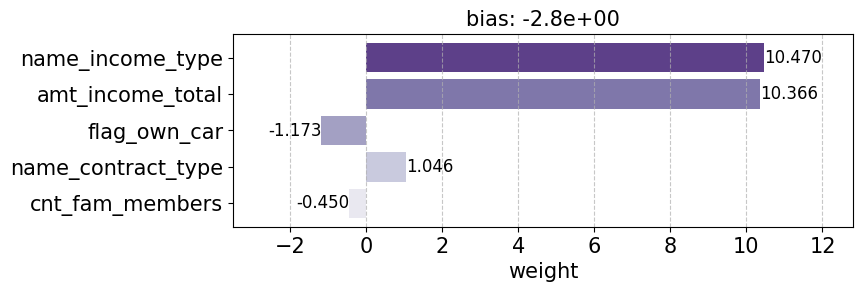

In [35]:
features = data.columns
model = clf
top_k = 5
num_features_to_plot = min(top_k, len(features))
weights = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_ 
sorted_idx = np.argsort(-np.abs(weights))
bias = model.intercept_[0] if not isinstance(model.intercept_, float) else model.intercept_
    
sorted_features = np.array(features)[sorted_idx][:top_k]
sorted_weights = weights[sorted_idx][:top_k]
    
plt.figure(figsize=(8, num_features_to_plot / 2))
ax = sns.barplot(x=sorted_weights, y=sorted_features, palette="Purples_r")
    
for container, weight in zip(ax.containers, sorted_weights):
    ax.bar_label(container, labels=[f"{weight:.3f}"], color="black",fontsize=12)
    
ax.margins(0.2, 0.05)
ax.set_title(f'bias: {bias:.1e}', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('weight', fontsize=15)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    
plt.show()

In [36]:
data1 = pd.read_csv('description.csv', encoding='latin1')
data1['Row'] = data1['Row'].str.lower()
data1.head(5)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,sk_id_curr,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,target,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,name_contract_type,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,code_gender,Gender of the client,NaN
4,7,application_{train|test}.csv,flag_own_car,Flag if the client owns a car,NaN


In [37]:
common_columns = list(set(sorted_features) & set(data1['Row'])) 

filtered_data1 = data1[data1['Row'].isin(common_columns)]

description_dict = {row.Row: row.Description for row in filtered_data1.itertuples()}

for feature in sorted_features:
  if feature in description_dict:
    print(f'Row: {feature}, description: {description_dict[feature]}')

Row: name_income_type, description: Clients income type (businessman, working, maternity leave,)
Row: amt_income_total, description: Income of the client
Row: flag_own_car, description: Flag if the client owns a car
Row: name_contract_type, description: Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application
Row: cnt_fam_members, description: How many family members does client have


Анализируя график, мы можем сделать вывод, что на вероятность дефолта в большей степени влияют тип занятости и доход клиента. При этом по тестовой выборке мы не можем однозначно сделать вывод, что если доход больше, то вероятность дефолта клиента ниже, так как в ней очень много клиентов с низким доходом и очень мало с высоким.

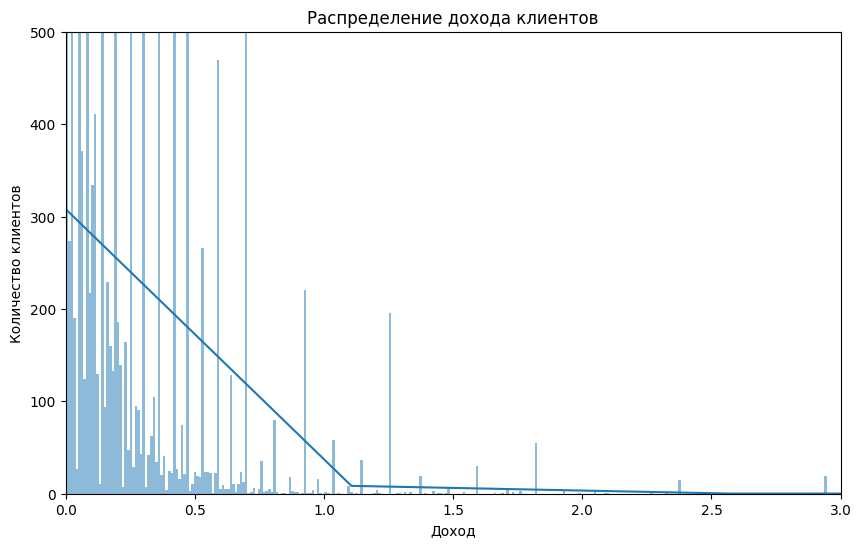

In [8]:
income = data_dict["tst"]['amt_income_total'].to_numpy()
income = (income - np.mean(income)) / np.std(income) # нормируем

plt.figure(figsize=(10, 6))
sns.histplot(income, kde=True)
plt.xlabel('Доход')
plt.ylabel('Количество клиентов')
plt.title('Распределение дохода клиентов')
plt.ylim(0, 500)
plt.xlim(0, 3)
plt.show()